In [1]:

NUM_PROC_MAP = 150 # expect 30 min with single process
PUSH_TO_HF = False

DEBUG = True
EPOCHS = 10
HF_USERNAME = None

In [2]:
import os

from dotenv import load_dotenv
load_dotenv()
import datasets
from datasets import DatasetDict
from datasets import load_dataset
import datasets
import torch
import json
from huggingface_hub import HfApi

import numpy as np

from scipy.stats import norm
from scipy.stats import f
from scipy.stats import lognorm
import plotting
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import torch
import datasets
from datasets import load_dataset
import util



DEBUG = False


In [3]:
from baseline_curricula import validate_training_duration_limitation
from itertools import product
import config 

# validate_training_duration_limitation("loris3/babylm_2024_10m_curriculum", "random.pt")

As in the official [preprocessing repo](https://github.com/babylm/babylm_data_preprocessing), we get the number of words via `line.split()`:

In [4]:
word_count = lambda d: len(d.split())
word_count_dataset = lambda dataset:sum([word_count(d) for d in dataset["text"]])

## New Curriculum based on Influence during learning on randomly shuffled data

In [5]:


from itertools import product

import config

jobs = [(d+"_"+t+"_"+"random", d,t) for d, t in product(config.datasets, config.model_types)]

In [6]:
jobs

[('loris3/babylm_2024_10m_curriculum_llama_random',
  'loris3/babylm_2024_10m_curriculum',
  'llama'),
 ('loris3/stratified_equitoken_10m_curriculum_llama_random',
  'loris3/stratified_equitoken_10m_curriculum',
  'llama'),
 ('loris3/stratified_10m_curriculum_llama_random',
  'loris3/stratified_10m_curriculum',
  'llama')]

In [7]:
from baseline_curricula import upload, split_into_epochs, repeat_for_ten_epochs

In [8]:
##########old
get_order_top_n_pct = lambda top_n_pct, df: torch.stack([torch.tensor(df[checkpoint].sort_values(ascending=False).head(int(len(df)*top_n_pct*0.01)).index.to_numpy()) for checkpoint in influence_cols])


In [ ]:
def lognorm_filter(size, **args):
    indices = np.arange(-size, size+1, 1)
    weights = lognorm.pdf(indices+1, **args)
    return weights / np.sum(weights)
dirac_filter = lambda size: np.eye(1, (size*2)+1, size, dtype=float).flatten()

def reweight_df(df, influence_cols, filter_weights):
    scores = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,filter_weights, mode="valid")[1:-1], axis=1, arr=df[influence_cols].to_numpy()))
    scores.columns = influence_cols
    df_reweighted = df.copy()
    df_reweighted[influence_cols] = scores
    df_reweighted["total"] = df_reweighted[influence_cols].sum(axis=1)
    return df_reweighted

apply_lognorm = lambda df : reweight_df(df, influence_cols, lognorm_filter(len(influence_cols), s=1, loc=0, scale=0.5))
apply_dirac = lambda df : reweight_df(df, influence_cols, dirac_filter(len(influence_cols)))

def get_shuffled_bins(df, bin_size=1000, ascending=False):
    torch.manual_seed(42)
    np.random.seed(42)
    curriculum =  [torch.tensor(
        np.concat(
            [
                np.random.permutation(bin) for bin in 
                np.array_split(df[checkpoint].sort_values(ascending=ascending).index.to_numpy(), indices_or_sections=len(df) // 1000)
            ]
        )
    )
    for checkpoint in influence_cols]
    return curriculum


def get_influence_top_50_twice_cp_shuffled(df): 
    torch.manual_seed(42)
    


    word_count = lambda d: {"words" : len(d["text"].split())}

    WORDS_PER_CHECKPOINT = 10000000 # there are 5 stages: 2*10M words = 100M total seen during training

    
    df["words"] = load_dataset(dataset_name)["train"].map(word_count, num_proc=100).to_pandas()["words"]
    curriculum = []
    for checkpoint in influence_cols:
        print("checkpoint", checkpoint)
        tokens_in_checkpoint = 0
        curriculum_checkpoint = []
        
        i = 0
        while tokens_in_checkpoint < WORDS_PER_CHECKPOINT: # the dataset assumes each stage is repeated for multiple epochs. we will therefore run out of documents before reaching the alloted number of tokens. just re-shuffle and continue
                                                #    we double-check the total number of tokens seen trough the curriculum below
            checkpoint_df_shuffled = df.sort_values(by=checkpoint, ascending=False).head(int(len(df)*50*0.01)).sample(frac=1, random_state=42+i)
            for idx, row in checkpoint_df_shuffled.iterrows():            
                if (tokens_in_checkpoint + row["words"]) <= WORDS_PER_CHECKPOINT:
                    curriculum_checkpoint.append(idx)
                    tokens_in_checkpoint += row["words"]
                else:
                    tokens_in_checkpoint += row["words"] # so that outer loop breaks
                    break
                
            print(i,tokens_in_checkpoint)
            i+=1
        curriculum.append(torch.tensor(curriculum_checkpoint)) # so that there are 2 epochs per stage
    return curriculum



def make_tracin_sandwich(df):
    torch.manual_seed(42)

    chunks = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), len(influence_cols))
    beneficial_chunks = chunks[0:len(chunks)//2]
    harmful_chunks = chunks[len(chunks)//2:]

    l = [tensor for pair in zip(beneficial_chunks, harmful_chunks) for tensor in pair] * 10


    influential_examples_sandwich = list(torch.tensor_split(torch.cat([chunk[torch.randperm(len(chunk))] for chunk in l]), len(influence_cols)))
    return influential_examples_sandwich

def influence_epoch_repetition(df):
    torch.manual_seed(42)
    
    word_count = lambda d: {"words" : len(d["text"].split())}
    df["words"] = load_dataset(dataset_name)["train"].map(word_count, num_proc=100).to_pandas()["words"]

    chunks = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), 10) # 10 stages
    print("CHUNKKK", len(chunks))
    WORDS_PER_CHUNK = 10000000
    df_chunks = [df.iloc[chunk] for chunk in chunks]
    curriculum = []
    for df_chunk in df_chunks:
        tokens_in_chunk = 0
        curriculum_chunk = []
        
        i = 0
        while tokens_in_chunk < WORDS_PER_CHUNK: 
                                                #    we double-check the total number of tokens seen trough the curriculum below
            chunk_df_shuffled = df_chunk.sample(frac=1, random_state=42+i)
            for idx, row in chunk_df_shuffled.iterrows():            
                if (tokens_in_chunk + row["words"]) <= WORDS_PER_CHUNK:
                    curriculum_chunk.append(idx)
                    tokens_in_chunk += row["words"]
                else:
                    tokens_in_chunk += row["words"] # so that outer loop breaks
                    break
                
            print(i,tokens_in_chunk)
            i+=1
        curriculum.append(torch.tensor(curriculum_chunk)) # so that there are 2 epochs per stage
    print("CCCCC22;2",len(curriculum))
    return curriculum






functions = {

    # "influence_epoch_repetition": influence_epoch_repetition,

    "influence_incr_bins_dirac": lambda df: get_shuffled_bins(apply_dirac(df), bin_size=1000, ascending=True),
    "influence_decr_bins_dirac": lambda df: get_shuffled_bins(apply_dirac(df), bin_size=1000, ascending=False),

#     "influence_incr_bins_lognorm": lambda df: get_shuffled_bins(apply_lognorm(df), bin_size=1000, ascending=True),
#     "influence_decr_bins_lognorm": lambda df: get_shuffled_bins(apply_lognorm(df), bin_size=1000, ascending=False),

#     "influence_incr_cp_dirac" : lambda df: [torch.tensor(apply_dirac(df)[checkpoint].sort_values(ascending=True).index.to_numpy()) for checkpoint in influence_cols],
#     "influence_decr_cp_dirac" : lambda df: [torch.tensor(apply_dirac(df)[checkpoint].sort_values(ascending=False).index.to_numpy()) for checkpoint in influence_cols],

#     "influence_incr_cp_lognorm" : lambda df: [torch.tensor(apply_lognorm(df)[checkpoint].sort_values(ascending=True).index.to_numpy()) for checkpoint in influence_cols],
#     "influence_decr_cp_lognorm" : lambda df: [torch.tensor(apply_lognorm(df)[checkpoint].sort_values(ascending=False).index.to_numpy()) for checkpoint in influence_cols],

#    "influence_top_50_cp_shuffled" : get_influence_top_50_twice_cp_shuffled,
#     "influence_tracin_sandwich" : make_tracin_sandwich

    
}

from baseline_curricula import validate_training_duration_limitation
from itertools import product
import config 

def create_curricula(df, influence_cols, dataset_name, model_type, curriculum="random.pt"):
    for name, function in functions.items():
        print(f"{model_type}_{name}.pt")
        new_curriculum = function(df)
        print(new_curriculum)
        plotting.plot_per_document_in_order(df[influence_cols],new_curriculum)
        plt.show()
        validate_training_duration_limitation(dataset_name, new_curriculum)
        upload(f"{model_type}_{name}.pt", new_curriculum, dataset_name, DEBUG)

    
   

./influence_mean_normalized/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum_train[0%:100%]_babylm_2024_10m_curriculum_train[0%:100%]
llama_influence_epoch_repetition.pt
CHUNKKK 10
0 282880
1 565760
2 848640
3 1131520
4 1414400
5 1697280
6 1980160
7 2263040
8 2545920
9 2828800
10 3111680
11 3394560
12 3677440
13 3960320
14 4243200
15 4526080
16 4808960
17 5091840
18 5374720
19 5657600
20 5940480
21 6223360
22 6506240
23 6789120
24 7072000
25 7354880
26 7637760
27 7920640
28 8203520
29 8486400
30 8769280
31 9052160
32 9335040
33 9617920
34 9900800
35 10000002
0 411365
1 822730
2 1234095
3 1645460
4 2056825
5 2468190
6 2879555
7 3290920
8 3702285
9 4113650
10 4525015
11 4936380
12 5347745
13 5759110
14 6170475
15 6581840
16 6993205
17 7404570
18 7815935
19 8227300
20 8638665
21 9050030
22 9461395
23 9872760
24 10000005
0 558159
1 1116318
2 1674477
3 2232636
4 2790795
5 3348954
6 3907113
7 4465272
8 5023431
9 5581590
10 6139749
11 6697908
12 7256067
13 7814226
14 8372385

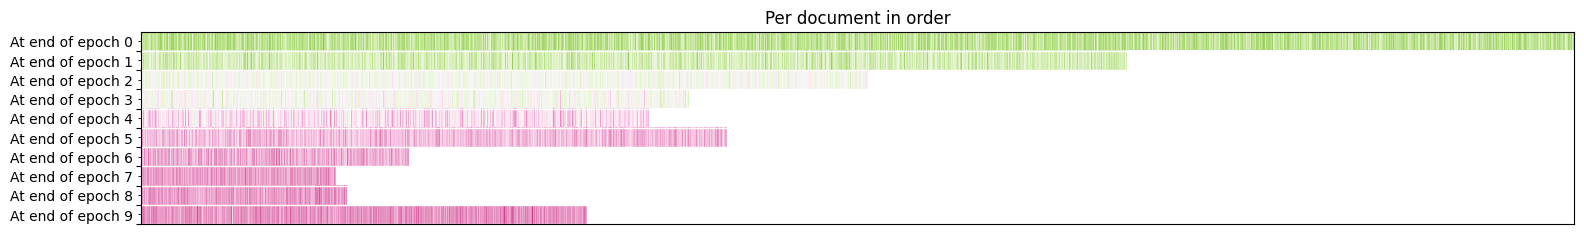

No files have been modified since last commit. Skipping to prevent empty commit.


./influence_mean_normalized/stratified_equitoken_10m_curriculum_llama_random/stratified_equitoken_10m_curriculum_train[0%:100%]_stratified_equitoken_10m_curriculum_train[0%:100%]
llama_influence_epoch_repetition.pt
CHUNKKK 10
0 1000000
1 2000000
2 3000000
3 4000000
4 5000000
5 6000000
6 7000000
7 8000000
8 9000000
9 10000000
0 1000000
1 2000000
2 3000000
3 4000000
4 5000000
5 6000000
6 7000000
7 8000000
8 9000000
9 10000000
0 1000000
1 2000000
2 3000000
3 4000000
4 5000000
5 6000000
6 7000000
7 8000000
8 9000000
9 10000000
0 1000000
1 2000000
2 3000000
3 4000000
4 5000000
5 6000000
6 7000000
7 8000000
8 9000000
9 10000000
0 1000000
1 2000000
2 3000000
3 4000000
4 5000000
5 6000000
6 7000000
7 8000000
8 9000000
9 10000000
0 1000000
1 2000000
2 3000000
3 4000000
4 5000000
5 6000000
6 7000000
7 8000000
8 9000000
9 10000000
0 1000000
1 2000000
2 3000000
3 4000000
4 5000000
5 6000000
6 7000000
7 8000000
8 9000000
9 10000000
0 1000000
1 2000000
2 3000000
3 4000000
4 5000000
5 6000000
6 70000

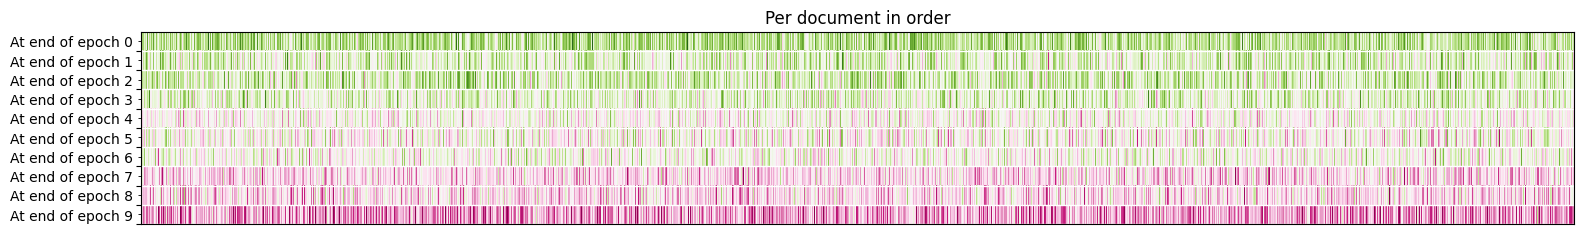

No files have been modified since last commit. Skipping to prevent empty commit.


./influence_mean_normalized/stratified_10m_curriculum_llama_random/stratified_10m_curriculum_train[0%:100%]_stratified_10m_curriculum_train[0%:100%]
llama_influence_epoch_repetition.pt
CHUNKKK 10
0 384479
1 768958
2 1153437
3 1537916
4 1922395
5 2306874
6 2691353
7 3075832
8 3460311
9 3844790
10 4229269
11 4613748
12 4998227
13 5382706
14 5767185
15 6151664
16 6536143
17 6920622
18 7305101
19 7689580
20 8074059
21 8458538
22 8843017
23 9227496
24 9611975
25 9996454
26 10000002
0 713157
1 1426314
2 2139471
3 2852628
4 3565785
5 4278942
6 4992099
7 5705256
8 6418413
9 7131570
10 7844727
11 8557884
12 9271041
13 9984198
14 10000002
0 978053
1 1956106
2 2934159
3 3912212
4 4890265
5 5868318
6 6846371
7 7824424
8 8802477
9 9780530
10 10000007
0 1210562
1 2421124
2 3631686
3 4842248
4 6052810
5 7263372
6 8473934
7 9684496
8 10000006
0 1341196
1 2682392
2 4023588
3 5364784
4 6705980
5 8047176
6 9388372
7 10000002
0 1403002
1 2806004
2 4209006
3 5612008
4 7015010
5 8418012
6 9821014
7 10000003

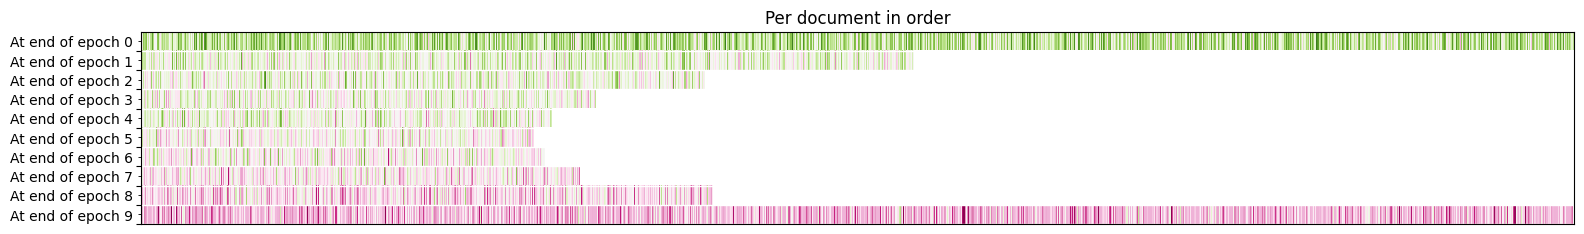

No files have been modified since last commit. Skipping to prevent empty commit.


In [10]:
import plotting
import matplotlib.pyplot as plt

# load influence data
for model_name, dataset_name, model_type in jobs:

    assert dataset_name in model_name


    RANDOM_CURRICULUM_NAME ="random.pt"


    influence_output_dir = os.path.join("./influence_mean_normalized", os.path.basename(model_name), "_".join([(os.path.basename(dataset_name) +"_"+f"train[0%:100%]")]*2))
    print(influence_output_dir)
    dataset = load_dataset(dataset_name)["train"]
    curriculum = util.get_curriculum(dataset_name, RANDOM_CURRICULUM_NAME)

    df = pd.DataFrame({int(result_checkpoint.replace("checkpoint-","")): torch.load(os.path.join(influence_output_dir,result_checkpoint),weights_only=True,map_location="cpu").numpy().flatten() for result_checkpoint in os.listdir(influence_output_dir)})
    df.sort_index(axis=1)

    df = df.reindex(sorted(df.columns, reverse=False), axis=1)
    influence_cols = df.columns
    df["total"] = df.sum(axis=1)
    df[["text", "source","stage"]] = dataset.to_pandas()
    df["document_lenght"] = df["text"].str.split().str.len()

    create_curricula(df, influence_cols, dataset_name, model_type, curriculum=RANDOM_CURRICULUM_NAME)



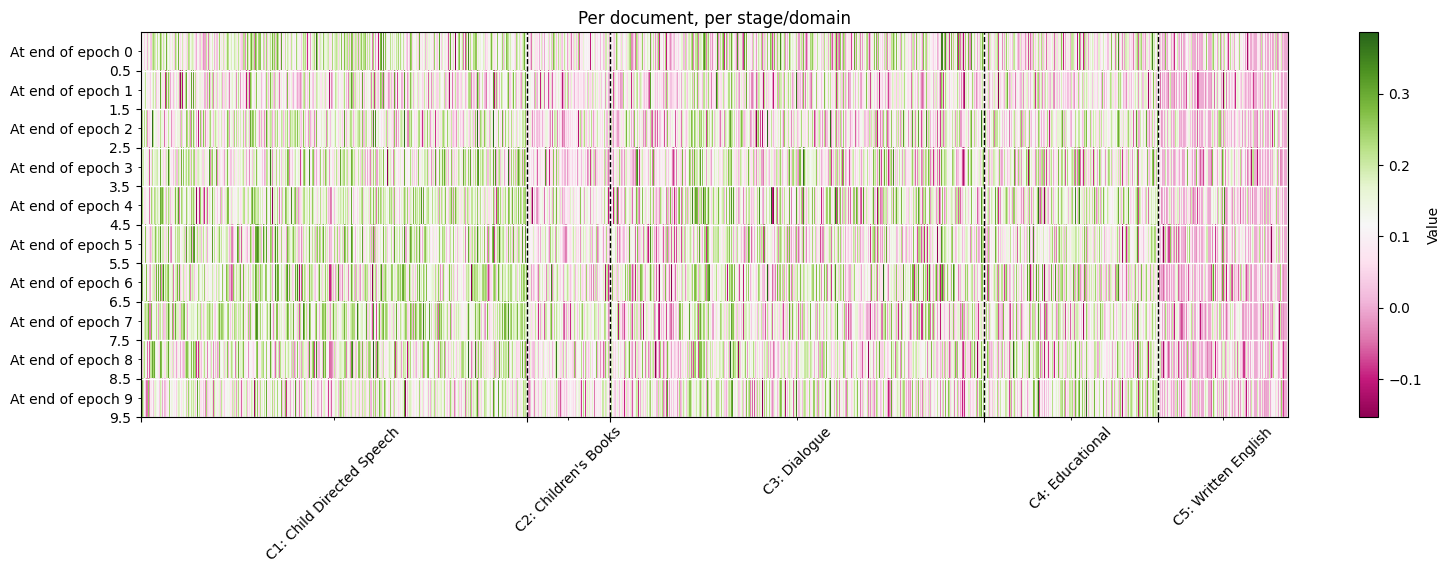

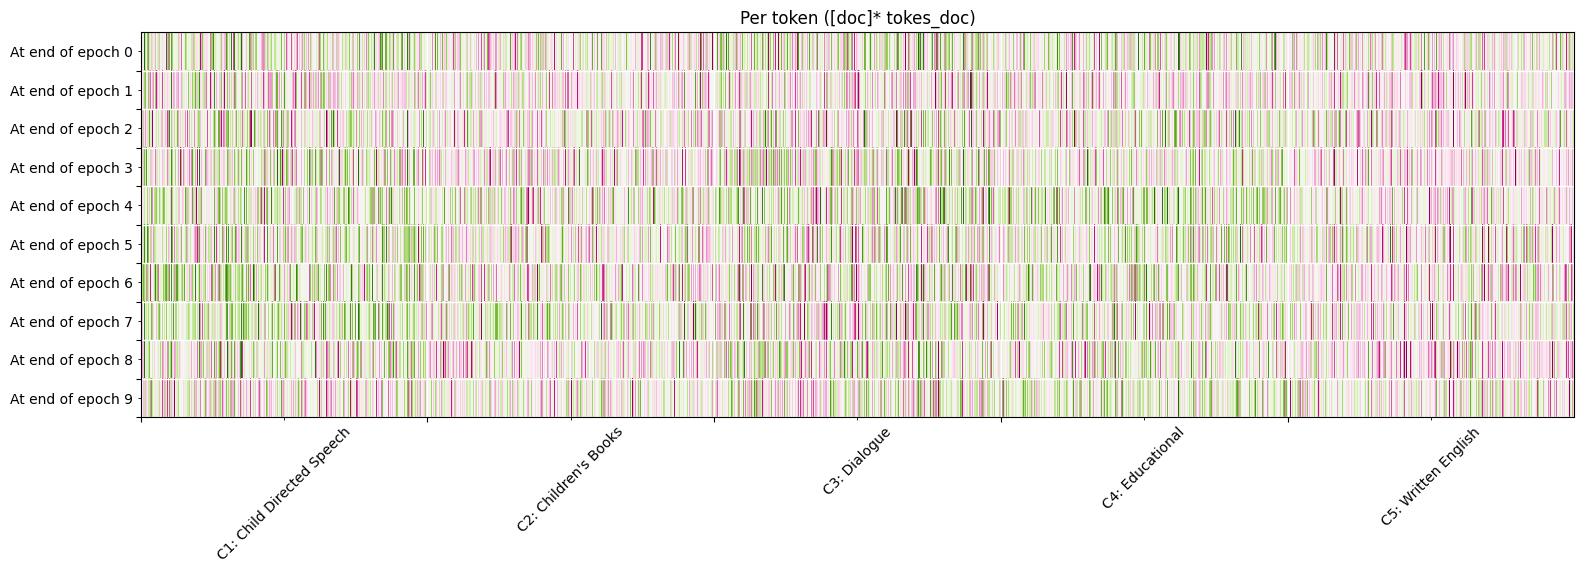

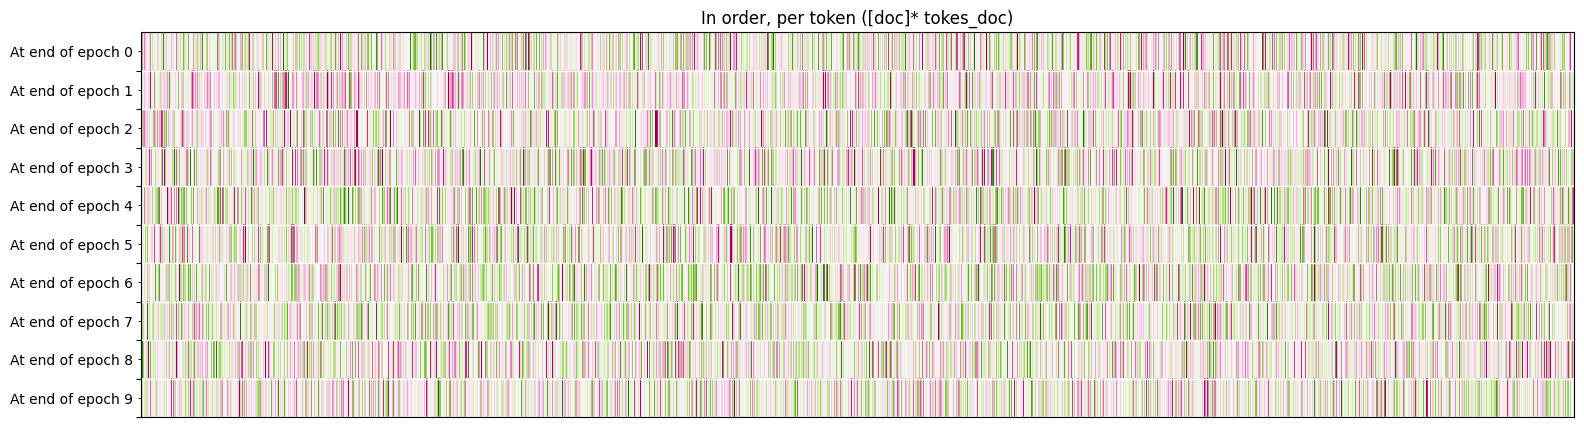

In [11]:
import plotting
plotting.plot_per_document_per_stage(df[influence_cols.to_list() + ["stage"]], curriculum)
plotting.plot_per_token_per_stage(df[influence_cols.to_list() + ["stage","document_lenght"]], curriculum)
plotting.plot_per_token_in_order(df[influence_cols.to_list() + ["stage","document_lenght"]], curriculum)

In [12]:






    # #############

    
    # if "equitoken" in dataset_name:
    #     lognorm_order = torch.repeat_interleave(lognorm_order,len(curriculum)//len(lognorm_order), dim=0)
        
    # plotting.plot_per_document_in_order(df, lognorm_order)
    # upload(lognorm_order, "lognorm")


    # lognorm_order_top_50_pct = get_order_top_n_pct(50,reweight_df(df, influence_cols, lognorm_filter(len(influence_cols), s=1, loc=0, scale=0.5)))
    # if "equitoken" in dataset_name:
    #     lognorm_order_top_50_pct = torch.repeat_interleave(lognorm_order_top_50_pct,len(curriculum)//len(lognorm_order_top_50_pct), dim=0)
    # plotting.plot_per_document_in_order(df, lognorm_order_top_50_pct)

    # upload(lognorm_order_top_50_pct, "lognorm_top_50_pct")



    # torch.manual_seed(42)
    # lognorm_order_top_50_pct_shuffled= torch.stack([row[torch.randperm(row.shape[0])] for row in lognorm_order_top_50_pct])
    # if "equitoken" in dataset_name:
    #     lognorm_order_top_50_pct_shuffled = torch.repeat_interleave(lognorm_order_top_50_pct_shuffled,len(curriculum)//len(lognorm_order_top_50_pct_shuffled), dim=0)
    # plotting.plot_per_document_in_order(df, lognorm_order_top_50_pct_shuffled)
    # upload(lognorm_order_top_50_pct_shuffled, "lognorm_top_50_pct_shuffled")


    # dirac_order = get_order_full(reweight_df(df, influence_cols, dirac_filter(len(influence_cols))))
    # if "equitoken" in dataset_name:
    #     dirac_order = torch.repeat_interleave(dirac_order,len(curriculum)//len(dirac_order), dim=0)
    # plotting.plot_per_document_in_order(df, dirac_order)
    # upload(dirac_order, "dirac")



    # get_order_positive_only = lambda df: [torch.tensor(df[checkpoint][df[checkpoint] >= 0].sort_values(ascending=False).index.to_numpy()) for checkpoint in influence_cols]
    # positive_only_order = get_order_positive_only(reweight_df(df, influence_cols, dirac_filter(len(influence_cols))))
    # if "equitoken" in dataset_name:
    #     positive_only_order = [positive_only_order[i] for i in torch.arange(0,len(positive_only_order)).repeat_interleave(len(curriculum)//len(positive_only_order))]
    # plotting.plot_per_document_in_order(df, positive_only_order)
    # upload(positive_only_order, "dirac_positive_only")



    # epochs = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), len(influence_cols))
    # epochs = [epoch.repeat(10) for epoch in epochs]
    # torch.manual_seed(42)
    # influential_examples_early_order = [epoch[torch.randperm(epoch.shape[0])] for epoch in epochs]
    # plotting.plot_per_document_in_order(df, influential_examples_early_order)
    # upload(influential_examples_early_order, "influential_examples_early")



    # halfs = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), 2)
    # halfs = [half.repeat(10) for half in halfs]
    # torch.manual_seed(42)
    # influential_examples_first_half_order = list(torch.tensor_split(torch.cat([half[torch.randperm(len(half))] for half in halfs]), len(influence_cols)))
    # plotting.plot_per_document_in_order(df, influential_examples_first_half_order)
    # upload(influential_examples_first_half_order, "influential_examples_first_half")


    # halfs = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), 2)
    # halfs = [half.repeat(10) for half in halfs]
    # torch.manual_seed(42)
    # influential_examples_first_half_order = list(torch.tensor_split(torch.cat([half[torch.randperm(len(half))] for half in halfs]), len(influence_cols)))
    # plotting.plot_per_document_in_order(df, influential_examples_first_half_order)
    # upload(influential_examples_first_half_order, "influential_examples_first_half")


    # thirds = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), 3)
    # thirds = [third.repeat(10) for third in thirds]
    # torch.manual_seed(42)
    # influential_examples_first_third_order = list(torch.tensor_split(torch.cat([third[torch.randperm(len(third))] for third in thirds]), len(influence_cols)))
    # plotting.plot_per_document_in_order(df, influential_examples_first_third_order)
    # upload(influential_examples_first_third_order, "influential_examples_first_third")



    # plotting.plot_per_document_in_order(df, influential_examples_sandwich)
    # upload(influential_examples_sandwich, "influential_examples_sandwich")
